In [1]:
# import required packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor, RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI
from sklearn.linear_model import RidgeCV, LogisticRegression
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from joypy import joyplot
from pycaret.datasets import get_data

In [2]:
# set seed
np.random.seed(0)
# get pre-cleaned insurance dataset from pycaret
data = get_data('insurance')
# remove last feature from X
X = data.iloc[:, :-1]
# get y
y = data.iloc[:, -1]
# convert y to (n,) np array
y = y.to_numpy().reshape(-1)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# switch sex and smoker to binary features
X['sex'] = X['sex'].map({'male': 1, 'female': 0})
X['smoker'] = X['smoker'].map({'yes': 1, 'no': 0})
X.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,southwest
1,18,1,33.770,1,0,southeast
2,28,1,33.000,3,0,southeast
3,33,1,22.705,0,0,northwest
4,32,1,28.880,0,0,northwest


In [4]:
# switch region to one-hot encoding
X = pd.get_dummies(X, columns=['region'], dtype = 'float')
X.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,0.0,1.0,0.0,0.0


In [5]:
# get proportion of X that smokes
smoker = X["smoker"]
print("Proportion of data that smokes: ", sum(smoker == 1)/len(smoker))
print("Proportion of data that doesn't smoke: ", sum(smoker == 0)/len(smoker))

Proportion of data that smokes:  0.20478325859491778
Proportion of data that doesn't smoke:  0.7952167414050823


Plot demonstrating subgroup impact on outcome:


<Figure size 1000x600 with 0 Axes>

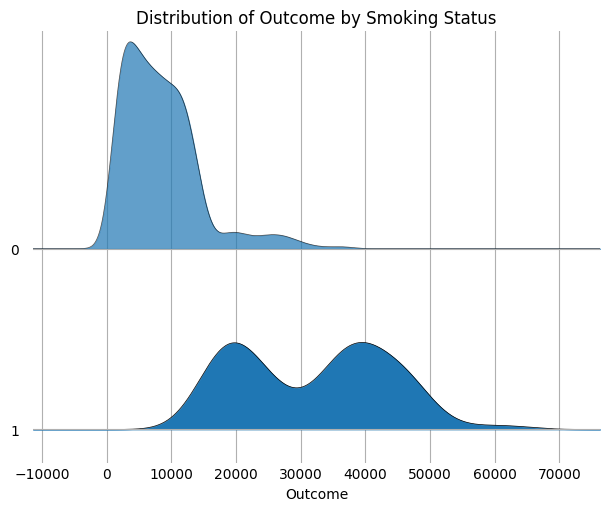

In [6]:
print("Plot demonstrating subgroup impact on outcome:")
# Create the joyplot
plt.figure(figsize=(10, 6))
joyplot(
    data=X.assign(y=y),
    by='smoker',
    column='y',
    fade=True,
    grid=True,
    linecolor='k',
    linewidth=0.5
)

plt.title('Distribution of Outcome by Smoking Status')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.show()

In [7]:
# split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=2)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [8]:
# fit RF model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# fit RF+ model
rf_plus = RandomForestPlusRegressor(rf_model = rf, prediction_model = RidgeCV())
rf_plus.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished


In [9]:
# get TreeSHAP importances and rankings
explainer = shap.TreeExplainer(rf)
shap_values = np.abs(explainer.shap_values(X_train, check_additivity=False))
shap_rankings = np.argsort(-shap_values, axis = 1)

In [10]:
# get LMDI+ importances and rankings
rfplus_explainer = RFPlusMDI(rf_plus)
lmdi_values = np.abs(rfplus_explainer.explain_linear_partial(np.asarray(X_train), y_train, l2norm=True, njobs = 1))
lmdi_rankings = rfplus_explainer.get_rankings(lmdi_values)

In [16]:
# sort lmdi_values based highest y to lowest y
sorted_indices = np.argsort(-y_train)
sorted_ytrain = y_train[sorted_indices]
sorted_lmdi_values = lmdi_values[sorted_indices]
sorted_lmdi_rankings = lmdi_rankings[sorted_indices]
sorted_shap_values = shap_values[sorted_indices]
sorted_shap_rankings = shap_rankings[sorted_indices]

In [17]:
np.arange(0, len(y_train), len(y_train)//20)

array([  0,  46,  92, 138, 184, 230, 276, 322, 368, 414, 460, 506, 552,
       598, 644, 690, 736, 782, 828, 874, 920])

In [18]:
sorted_ytrain[::len(y_train)//20]

array([63770.42801, 40003.33225, 34806.4677 , 25309.489  , 20773.62775,
       17179.522  , 13887.204  , 12629.1656 , 11552.904  , 10713.644  ,
        9583.8933 ,  8604.48365,  7731.85785,  6770.1925 ,  5972.378  ,
        5031.26955,  4428.88785,  3597.596  ,  2727.3951 ,  1981.5819 ,
        1534.3045 ])

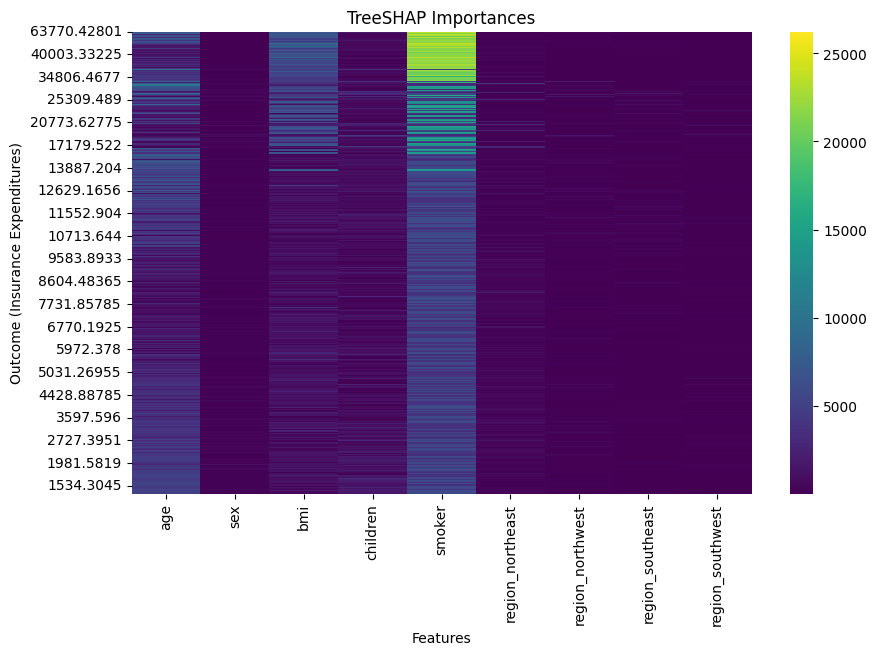

In [21]:
# plot heatmap of LMDI+ importances based on true y
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_shap_values, cmap='viridis')
plt.title('TreeSHAP Importances')
plt.xlabel('Features')
plt.ylabel('Outcome (Insurance Expenditures)')
plt.yticks(ticks = np.arange(0, len(y_train), len(y_train)//20), labels = sorted_ytrain[::len(y_train)//20])
plt.xticks(ticks = np.arange(X_train.shape[1]) + 0.5, labels = X_train.columns, rotation = 90)
plt.show()

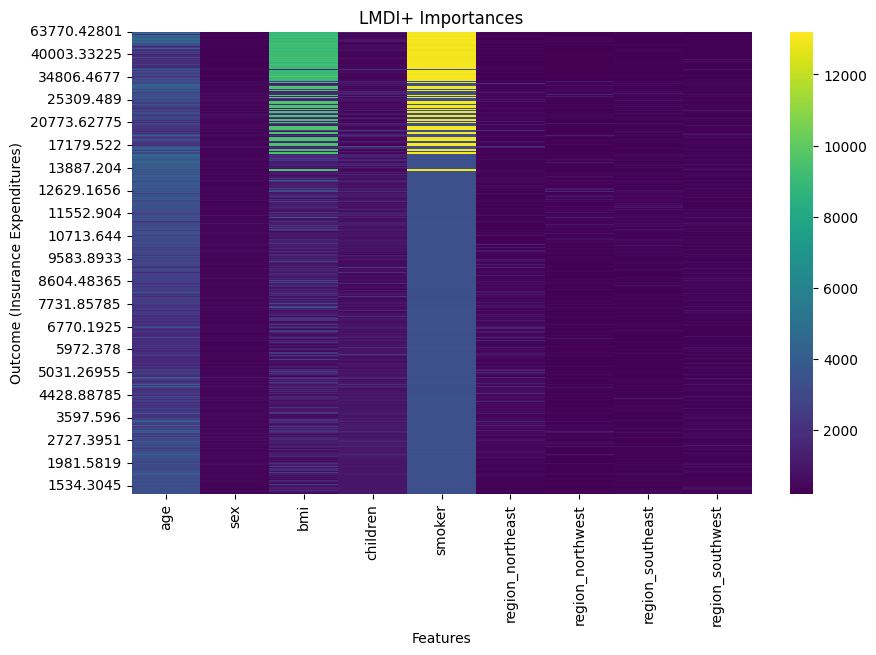

In [22]:
# plot heatmap of LMDI+ importances based on true y
plt.figure(figsize=(10, 6))
sns.heatmap(sorted_lmdi_values, cmap='viridis')
plt.title('LMDI+ Importances')
plt.xlabel('Features')
plt.ylabel('Outcome (Insurance Expenditures)')
plt.yticks(ticks = np.arange(0, len(y_train), len(y_train)//20), labels = sorted_ytrain[::len(y_train)//20])
plt.xticks(ticks = np.arange(X_train.shape[1]) + 0.5, labels = X_train.columns, rotation = 90)
plt.show()

In [42]:
lmdi_sub_imp = pd.concat([X_train["smoker"].reset_index(drop=True), pd.DataFrame(lmdi_rankings)], axis=1)

In [43]:
shap_sub_imp = pd.concat([X_train["smoker"].reset_index(drop=True), pd.DataFrame(shap_rankings)], axis=1)

In [44]:
lmdi_mean_rankings = lmdi_sub_imp.groupby('smoker', observed=False).mean().reset_index()
# rank features for each row
lmdi_ranked_mean_rankings = lmdi_mean_rankings.drop(columns=["smoker"]).rank(axis=1)
lmdi_ranked_mean_rankings.columns = X.columns
print("Subgroup feature rankings for LMDI+:")
lmdi_ranked_mean_rankings

Subgroup feature rankings for LMDI+:


,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,4.0,1.0,2.0,3.0,7.0,5.0,6.0,9.0,8.0
1,5.0,2.0,1.0,3.0,6.0,4.0,7.0,8.0,9.0


In [45]:
shap_mean_rankings = shap_sub_imp.groupby('smoker', observed=False).mean().reset_index()
# rank features for each row
shap_ranked_mean_rankings = shap_mean_rankings.drop(columns=["smoker"]).rank(axis=1)
shap_ranked_mean_rankings.columns = X.columns
print("Subgroup feature rankings for TreeSHAP:")
shap_ranked_mean_rankings

Subgroup feature rankings for TreeSHAP:


,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,3.0,1.0,2.0,4.0,6.0,5.0,7.0,8.0,9.0
1,5.0,2.0,1.0,3.0,6.0,4.0,7.0,8.0,9.0


In [48]:
def mask_feature(row, i, ranked_mean_rankings):
    return ranked_mean_rankings.iloc[int(row['smoker'])].sort_values().index[i]


In [49]:
X_train_copy = X_train.copy()
mse_list = []
mse_list.append(np.mean((rf.predict(X_train_copy) - y_train)**2))
for i in range(X_train.shape[1]):
    # if the gender is 0, mask the feature with importance == i in the 0th row of shap_ranked_mean_rankings
    for j in range(X_train.shape[0]):
        feature_to_mask = mask_feature(X_train.iloc[j,], i, shap_ranked_mean_rankings)
        X_train_copy.loc[j, feature_to_mask] = X_train[feature_to_mask].mean()
    mse = np.mean((rf.predict(X_train_copy) - y_train)**2)
    mse_list.append(mse)
mse_arr_shap = np.array(mse_list)
# get difference between elements of mse_list
diff_shap = np.abs(np.diff(mse_arr_shap))
# get cumulative sum of differences
cumulative_diff_shap = np.cumsum(diff_shap)

In [50]:
X_train_copy = X_train.copy()
mse_list = []
mse_list.append(np.mean((rf_plus.predict(X_train_copy) - y_train)**2))
for i in range(X_train.shape[1]):
    # if the gender is 0, mask the feature with importance == i in the 0th row of shap_ranked_mean_rankings
    for j in range(X_train.shape[0]):
        feature_to_mask = mask_feature(X_train.iloc[j,], i, lmdi_ranked_mean_rankings)
        X_train_copy.loc[j, feature_to_mask] = X_train[feature_to_mask].mean()
    mse = np.mean((rf_plus.predict(X_train_copy) - y_train)**2)
    mse_list.append(mse)
mse_arr_lmdi = np.array(mse_list)
# get difference between elements of mse_list
diff_lmdi = np.abs(np.diff(mse_arr_lmdi))
# get cumulative sum of differences
cumulative_diff_lmdi = np.cumsum(diff_lmdi)

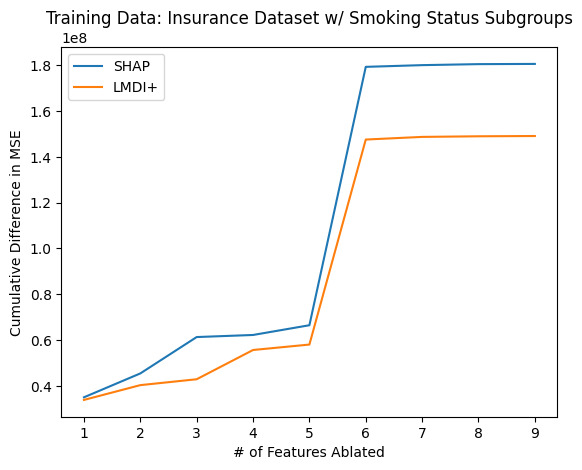

In [51]:
# plot cumulative differences in mse vs number of features ablated
plt.plot(cumulative_diff_shap, label = 'SHAP')
plt.plot(cumulative_diff_lmdi, label = 'LMDI+')
plt.xlabel('# of Features Ablated')
plt.ylabel('Cumulative Difference in MSE')
# x ticks should be labeled 1-X_train.shape[1]
plt.xticks(np.arange(0, X_train.shape[1], 1), np.arange(1, X_train.shape[1]+1, 1))
plt.title('Training Data: Insurance Dataset w/ Smoking Status Subgroups')
plt.legend()
plt.show()


In [52]:
X_test_copy = X_test.copy()
mse_list = []
mse_list.append(np.mean((rf.predict(X_test_copy) - y_test)**2))
for i in range(X_test.shape[1]):
    # if the gender is 0, mask the feature with importance == i in the 0th row of shap_ranked_mean_rankings
    for j in range(X_test.shape[0]):
        feature_to_mask = mask_feature(X_test.iloc[j,], i, shap_ranked_mean_rankings)
        X_test_copy.loc[j, feature_to_mask] = X_test[feature_to_mask].mean()
    mse = np.mean((rf.predict(X_test_copy) - y_test)**2)
    mse_list.append(mse)
mse_arr_shap = np.array(mse_list)
# get difference between elements of mse_list
diff_shap = np.abs(np.diff(mse_arr_shap))
# get cumulative sum of differences
cumulative_diff_shap_test = np.cumsum(diff_shap)

In [53]:
X_test_copy = X_test.copy()
mse_list = []
mse_list.append(np.mean((rf_plus.predict(X_test_copy) - y_test)**2))
for i in range(X_test.shape[1]):
    # if the gender is 0, mask the feature with importance == i in the 0th row of shap_ranked_mean_rankings
    for j in range(X_test.shape[0]):
        feature_to_mask = mask_feature(X_test.iloc[j,], i, lmdi_ranked_mean_rankings)
        X_test_copy.loc[j, feature_to_mask] = X_test[feature_to_mask].mean()
    mse = np.mean((rf_plus.predict(X_test_copy) - y_test)**2)
    mse_list.append(mse)
mse_arr_lmdi = np.array(mse_list)
# get difference between elements of mse_list
diff_lmdi = np.abs(np.diff(mse_arr_lmdi))
# get cumulative sum of differences
cumulative_diff_lmdi_test = np.cumsum(diff_lmdi)

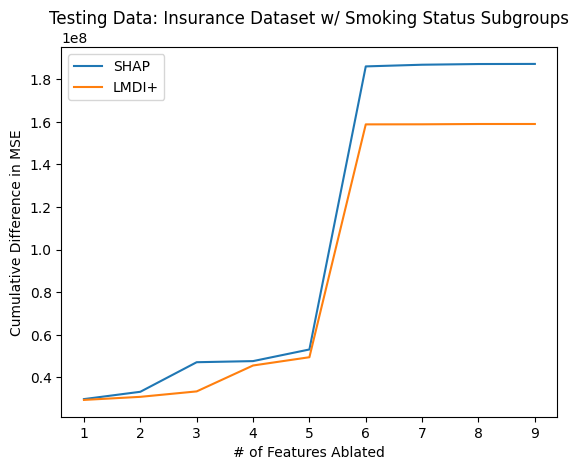

In [54]:
# plot cumulative differences in mse vs number of features ablated
plt.plot(cumulative_diff_shap_test, label = 'SHAP')
plt.plot(cumulative_diff_lmdi_test, label = 'LMDI+')
plt.xlabel('# of Features Ablated')
plt.ylabel('Cumulative Difference in MSE')
# x ticks should be labeled 1-X_train.shape[1]
plt.xticks(np.arange(0, X_train.shape[1], 1), np.arange(1, X_train.shape[1]+1, 1))
plt.title('Testing Data: Insurance Dataset w/ Smoking Status Subgroups')
plt.legend()
plt.show()